<a href="https://colab.research.google.com/github/achanbour/st311-cancer-detection/blob/main/st311_project_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"anastasiachambour","key":"5a87a9488ad9031aad88989a15abeb37"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download histopathologic-cancer-detection

100% 6.30G/6.31G [00:31<00:00, 215MB/s]
100% 6.31G/6.31G [00:31<00:00, 212MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("histopathologic-cancer-detection.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/input")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the required dependencies

In [ ]:
import os #For training time
import numpy as np 
import pandas as pd
from PIL import Image #For plotting images
import matplotlib.pyplot as plt #For plotting the training
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split #For splitting data into test and train
import torch #For pytorch
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset #For the dataloader
import torch.optim as optim
import cv2
from time import sleep
from tqdm import tqdm

## Loading and subsetting data

### Setting the dataloader path and downloading the lavels

In [ ]:
train_path = "/kaggle/input/train"
test_path = "/kaggle/input/test"
df_train = pd.read_csv("/kaggle/input/train_labels.csv")

### Splitting the data into train and validation sets

In [ ]:
train_df, validate_df = train_test_split(df_train, test_size=0.2)
print(f'{len(os.listdir(train_path))} pictures in the training set.')
print(f'{len(os.listdir(test_path))} pictures in validation set.')


220025 pictures in the training set.
57458 pictures in validation set.


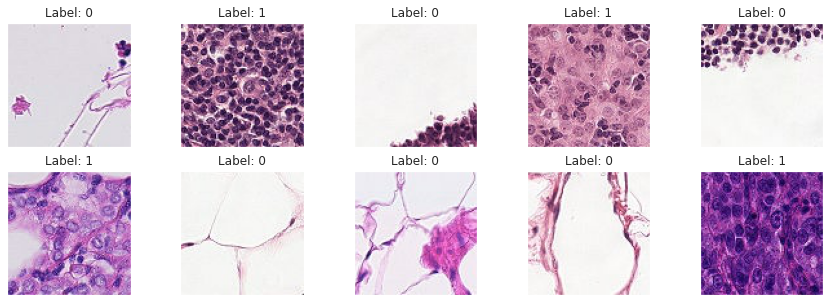

In [ ]:
# Plotting a grid of images from the test set
fig = plt.figure(figsize=(15, 5))
train_imgs = os.listdir("/kaggle/input/train/")
for i, img in enumerate(np.random.choice(train_imgs, 10)):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    im = Image.open("/kaggle/input/train/" + img)
    plt.imshow(im)
    tlt = df_train.loc[df_train['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {tlt}')


### Creating the custom dataset class

In [ ]:
class CancerDataset(Dataset):
    '''
    This custom class allows us to perform transformations on the images in the dataset
    '''
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

## Defining the image resizing function

In [ ]:
def resizeImages(size):
    transform_train = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20), 
                                      transforms.ToTensor(),
                                      transforms.Resize(size),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])
    
    transform_val = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(), 
                                      transforms.Resize(size),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])
    
    transform_test = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.ToTensor(),
                                      transforms.Resize(size),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])
    batch_size = 100
    train_dataset = CancerDataset(df_data=train_df, data_dir=train_path, transform=transform_train)
    val_dataset = CancerDataset(df_data=validate_df, data_dir=train_path, transform=transform_val)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    return train_dataloader, val_dataloader

## Defining a baseline Convolutional Neural Network

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv3 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv5 = nn.Sequential(
                        nn.Conv2d(256, 512, 3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.fc=nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(256),
                nn.Dropout(0.4),
                nn.Linear(256, 2))
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #print(x.shape)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x


## Defining the AlexNet Class


In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=2)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Defining the training function

In [ ]:
def modelTrain(net, train_dl, val_dl, criterion, optimizer, epoch_num, learning_rate):
  
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
  
  model = net.to(device=device)
  loss_hist_train=[]
  loss_hist_val=[]

  for epoch in tqdm(range(epoch_num)): 
      train_loss = 0.0
      valid_loss = 0.0
    
      for batch_idx, (data, targets) in enumerate(train_dl):
          data = data.to(device=device)
          targets = targets.to(device=device)

          ## Forward Pass
          output = model(data)
          loss = criterion(output,targets)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          loss_hist_train.append(train_loss)
      print(f"Loss in epoch {epoch} :::: {train_loss/len(train_dl)}")

      model.eval()
      with torch.no_grad():
          num_correct = 0
          num_samples = 0
          for batch_idx, (data,targets) in enumerate(val_dl):
              data = data.to(device=device)
              targets = targets.to(device=device)
              ## Forward Pass
              output = model(data)
              _, predictions = torch.max(output.data, 1)
              num_correct += (predictions == targets).sum()
              num_samples += predictions.size(0)
          print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}")
  return model
      

In [ ]:
# Training the basic CNN

train_dl, val_dl = resizeImages(32)
print(len(train_dl), len(val_dl))

net = CNN()
learning_rate = 0.002
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning

modelTrain(net, train_dl, val_dl, criterion, optimizer, 10, learning_rate)

1760 440


  0%|          | 0/10 [00:00<?, ?it/s]

Loss in epoch 0 :::: 0.3783007224683057


  0%|          | 0/10 [06:47<?, ?it/s]


KeyboardInterrupt: ignored

## Pre-trained ResNet18 Model

In [ ]:
# Importing the pre-trained model

resnet = models.resnet18(pretrained=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Adjusting the final fully-connected layer to adapt the binary classification problem

resnet.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=512,
        out_features=2
    ),
    torch.nn.Sigmoid()
)

In [ ]:
train_dl, val_dl = resizeImages(224)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.02
optimizer = torch.optim.Adam(resnet.parameters(),lr=learning_rate)

modelTrain(resnet, train_dl, val_dl, criterion, optimizer, 10, learning_rate)

  0%|          | 0/10 [00:04<?, ?it/s]


KeyboardInterrupt: ignored